# Machine Learning LAB 2: SUPPORT VECTOR MACHINES

Course 2023/24: *M. Caligiuri*, *P. Talli*, *F. Lincetto*, *F. Chiariotti*, *P. Zanuttigh*

The notebook contains some simple tasks to be performed with **SUPPORT VECTOR MACHINES (SVM)**.

Complete all the **required code sections** and **answer to all the questions**.

### IMPORTANT for the evaluation score:

1. **Read carefully all cells** and **follow the instructions**.
2. **Re-run all the code from the beginning** to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebooks.
3. Make sure to fill the code in the appropriate places **without modifying the template**, otherwise you risk breaking later cells.
4. Please **submit the jupyter notebook file (.ipynb)**, do not submit python scripts (.py) or plain text files. **Make sure that it runs fine with the restat&run all command**.
5. **Answer the questions in the appropriate cells**, not in the ones where the question is presented.

## Weather Classification with Support Vector Machines

In this notebook we are going to explore the use of Support Vector Machines (SVM) for weather classification. We will use a dataset collected using the Luxottica **iSee** glasses. These devices provide multiple **sensors mounted inside the glasses**, which can be accessed through a bluetooth connection.

![I-SEE Glasses](data/isee.png "I-SEE")

The dataset corresponds to 8 hours of atmospherical data recordings sampled every 3 seconds.

The dataset labels are the following:

| ID  | Label       |
| :-: | :-:         |
| 0   | Sunny       |
| 1   | Rain        |
| 2   | Cloudy      |
| 3   | Mostly Clear|

---

## Preliminary step

Place your **name** and **ID number** (matricola) in the cell below. <br>
Also recall to **save the file as Surname_Name_LAB02.ipynb**, failure to do so will incur in a **lower grade**.

**Student name**: Ada D'Iorio

**ID Number**: 2092320

---

## Import all the necessary Python libraries

In [1]:
%matplotlib inline

import typing as tp
import numpy as np
import itertools
from matplotlib import pyplot as plt
import sklearn.metrics as skm
from sklearn.svm import SVC #algoritmo che permette di eseguire l'SVC 
from sklearn import linear_model
import random

---

## Define the heplper functions

In this section you will find some helper functions (some already implemented, some to be implemented by you) that will be used in the following sections.
1. `load_dataset` -> to load the dataset from the file `data/lux.npz`,
2. `plot_input` -> to plot the input data,
3. `k_split` ->  to split the trainig dataset in k different folds,
4. `k_fold_cross_validation` -> to perform the k-fold cross validation.

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [2]:
# Helper function to load the dataset
def load_dataset(path: str) -> tp.Tuple[np.ndarray, np.ndarray]:
    with np.load(path) as data:
        x, y = data["x"], data["y"]
        
        # Normalize the data
        x -= x.mean(axis=0)
        x /= x.std(axis=0)
        
    return x, y

In [3]:
# Function for plotting a image and printing the corresponding label
def plot_input(X_matrix: np.ndarray, labels: np.ndarray) -> None:
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    cmap = plt.cm.get_cmap('Accent', 4)
    im = ax.scatter(X_matrix[:,0], X_matrix[:,1], X_matrix[:,2], c=labels, cmap=cmap)
    im.set_clim(-0.5, 3.5)
    cbar=fig.colorbar(im, ticks=[0,1,2,3], orientation='vertical', cmap=cmap)
    cbar.ax.set_yticklabels(['Sunny', 'Rainy','Cloudy', 'Mostly clear']) 

In [4]:
def k_split(x: np.ndarray, y: np.ndarray, k: int, shuffle: bool = True) -> tp.Tuple[list[np.ndarray], list[np.ndarray]]:
    # Shuffle the dataset
    if shuffle:  # rimescolo il dataset prima di dividerlo
        # Create a list of indices
        idx = np.arange(x.shape[0])  # creo una lista di indici della stessa lunghezza di x
        # Randomly shuffle the indices
        np.random.shuffle(idx)
        # Shuffle the dataset
        x = x[idx]  # ridistribuisco gli elementi di x ed y
        y = y[idx]

    # Split the dataset in k folds

    num_elements = x.shape[0] // k  # devo frazionare x in k folds, quindi ogni fold deve contenere un numero di elementi dato da questo rapporto
    #X_fold = np.empty(shape=(1,3))
    #Y_fold = np.empty(shape=(1,))
    X_fold = []  # creo una lista per contenere tutti i folds
    Y_fold = []

    for i in range(k):
        start = i * num_elements
        end = (i+1) * num_elements
        X_fold.append(x[start:end]) 
        Y_fold.append(y[start:end])  # prendo tutti gli elementi che vanno da i a j

    return X_fold, Y_fold  # splitto il dataset in k parti e restituisco una lista di liste di dataset


In [5]:
def k_fold_cross_validation(x_train: np.ndarray, y_train: np.ndarray, k: int, model: SVC, parameters: dict) -> \
tp.Tuple[tuple, tuple]:
    # Define the folds for the cross validation
    x_folds, y_folds = k_split(x_train, y_train, k)  # devo restituire i fold per x ed y
    #print(len(x_folds), len(y_folds))

    # Build a list containing all of the possible combinatioon of parameters
    params = list(
        itertools.product(*parameters.values()))  # considero tutte le possibili combinazioni dei parametri di ingresso

    # Initialize the dictionary of results
    results = {k: 0 for k in params}

    # For each param combination, perform the SVM training and testing
    for param in params:
        param = dict(zip(parameters.keys(), param))  # i parametri sono delle grandezze che devo passare all'SVC

        fold_accuracies = []  # devo calcolare l'accuracy per ogni combinazione di parametri

        for i in range(k):  # dovrebbe iterare su ciascuno dei fold e usarne uno dei k per train ed uno dei k-1 per test
            x_val = x_folds[i]
            y_val = y_folds[i]

            x_train = np.concatenate([x_folds[j] for j in range(k) if j!=i])

            y_train = np.concatenate([y_folds[j] for j in range(k) if j!= i])
            svm = SVC(**param)

            svm.fit(x_train, y_train)  # traino l'algoritmo su questi set

            y_pred = svm.predict(x_val)
            fold_accuracies.append(
                skm.accuracy_score(y_val, y_pred)) 

        # Compute the mean accuracy
        results[tuple(param.values())] = round(np.mean(fold_accuracies), 4)

    # Find the best parameters
    best_parameters = dict(zip(parameters.keys(), params[np.argmax(list(results.values()))]))
    best_accuracy = np.max(list(results.values()))
    best = (best_parameters, best_accuracy)
    
    

    # Add the param name to the results
    results = [({k: v for k, v in zip(parameters.keys(), p)}, a) for p, a in results.items()]

    return best, results


---

## A) Hyper-parameter search

### TO DO (A.0)

**Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: 1234567 + 1

In [6]:
# fix your ID ("numero di matricola") and the seed for random generator
# as usual you can try different seeds by adding a constant to the number:
# ID = 1234567 + X
ID = 2092320 # YOUR ID (replace None with your ID)
np.random.seed(ID)

Before proceding to the training steps, we **load the dataset and split it** in training and test set (while the **training** set is **typically larger**, here we set the number of training samples to 1000 and 4000 for the test data).
The **split** is **performed after applying a random permutation** to the dataset, such permutation will **depend on the seed** you set above.

In [7]:
# Load the dataset using the helper function
X, y = load_dataset("data/lux.npz")
print(X.shape, y.shape)


(15099, 3) (15099,)


In [8]:
# The task is quite easy, let's add noise to make it more challenging!
# You can try without noise (comment the next 2 lines, easy task), with the suggested amount of noise,
# or play with the suggested amount of noise 

noise = np.random.normal(0, 0.1, X.shape)
X = X + noise
X[0]


array([-0.11625978, -0.8316976 ,  1.5231882 ])

### TO DO (A.1)

**Divide** the **data into training and test set** (for this part use 1000 samples in the **first** set, 4000 in the **second** one). Make sure that each label is present at least 10 times in training. If it is not, then keep adding permutations to the initial data until this happens.


In [9]:
# Random permute the data and split into training and test taking the first 1000
# data samples as training and 4000 samples as test
permutation = np.random.permutation(len(X)) 

X = X[permutation]
y = y[permutation]

m_training = 1000
m_test = 4000

X_train = X[:m_training]
X_test = X[m_training:m_training+m_test]
y_train = y[:m_training]
y_test = y[m_training:m_training+m_test]
print("X_train shape:", X_train.shape,"X_test shape:", X_test.shape,"||","y_train shape:",  y_train.shape,"y_test shape:", y_test.shape)

labels, freqs = np.unique(y_train, return_counts=True) 
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

X_train shape: (1000, 3) X_test shape: (4000, 3) || y_train shape: (1000,) y_test shape: (4000,)
Labels in training dataset:  [0. 1. 2. 3.]
Frequencies in training dataset:  [392 165 392  51]


C:\Users\adadi\AppData\Local\Temp\ipykernel_17988\31676135.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Accent', 4)


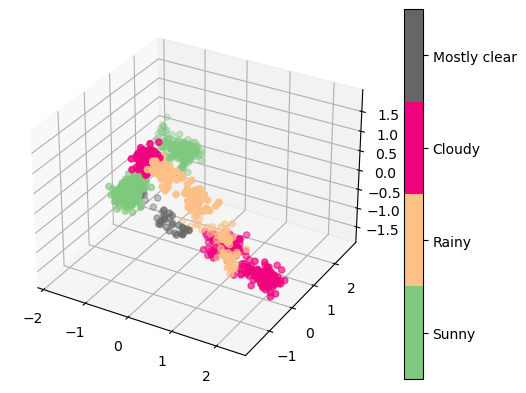

In [10]:
#Let's try the plotting function
plot_input(X_train,y_train)

### TO DO (A.2)

Use a SVM classfier with cross validation to pick a model. Use a 4-fold cross-validation. Let's start with a Linear kernel.

RESULTS FOR LINEAR KERNEL
Best parameter set found:
{'C': 10}
Score with best parameter:
0.987
All scores on the grid:
{'C': 0.01}: 78.40%
{'C': 0.1}: 89.60%
{'C': 1}: 97.70%
{'C': 10}: 98.70%


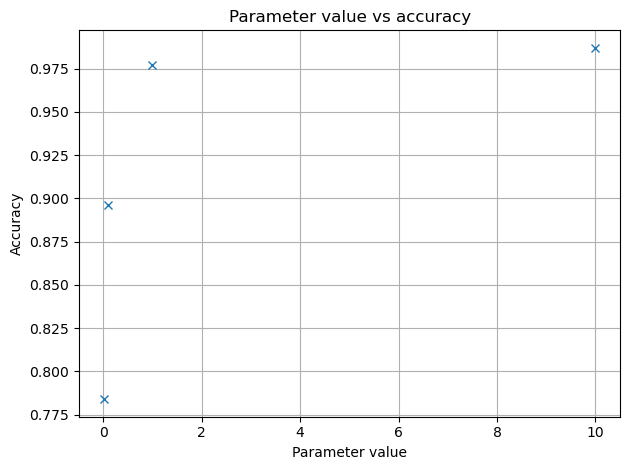

In [11]:
# Parameters for linear SVM
parameters = {'C': [ 0.01, 0.1, 1, 10]}
best_c = []
best_k = ['linear']
best_acc = []

# Define the model (without parameters)
svm = SVC(kernel='linear') #genero il modello per il kernel 
#svm.fit(X_train, y_train) #traino il mio modello lineare sul set di dati 
#svm.predict(X_test)

# Perform the K-fold cross validation 
num_folds = 4  #anche se k è uguale a 5 mi divide il dataset in 4 

best, results = k_fold_cross_validation(X_train, y_train, k = num_folds, model = SVC, parameters = parameters)
best_c.append(list(best[0].values()))

best_acc.append(best[1])


print ('RESULTS FOR LINEAR KERNEL')

print("Best parameter set found:")
print(best[0]) #valori di parametri ed accuracy

print("Score with best parameter:")
print(best[1])
print("All scores on the grid:") #riporto tutti i valori di accuracy con i rispettivi valori dei parametri 
for param, acc in results:
    print(f'{param}: {acc*100:.2f}%')
VALORI_PARAMETRO = []
VALORI_ACCURACY = []
for i in range(len(results)):
    VALORI_PARAMETRO.append(list(results[i][0].values()))
    VALORI_ACCURACY.append(results[i][1])
    

plt.plot(VALORI_PARAMETRO, VALORI_ACCURACY, marker = 'x', linestyle='')

plt.xlabel("Parameter value")
plt.ylabel("Accuracy")
plt.title("Parameter value vs accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()



### TO DO (A.3)

Pick a model for the Polynomial kernel with degree=2.

RESULTS FOR POLY DEGREE=2 KERNEL
Best parameter set found:
{'C': 1, 'gamma': 1.0}
None
Score with best parameter:
0.985
None
All scores on the grid:
{'C': 0.01, 'gamma': 0.01} 0.375
{'C': 0.01, 'gamma': 0.1} 0.716
{'C': 0.01, 'gamma': 1.0} 0.784
{'C': 0.1, 'gamma': 0.01} 0.65
{'C': 0.1, 'gamma': 0.1} 0.844
{'C': 0.1, 'gamma': 1.0} 0.947
{'C': 1, 'gamma': 0.01} 0.791
{'C': 1, 'gamma': 0.1} 0.947
{'C': 1, 'gamma': 1.0} 0.985


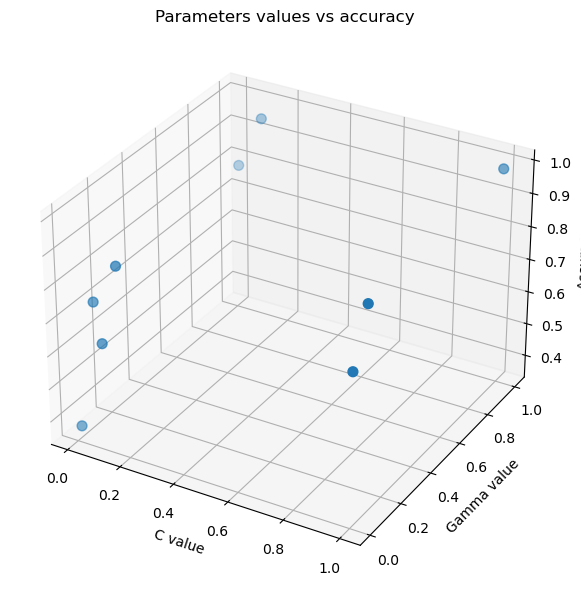

In [12]:
# Parameters for linear SVM
parameters = {'C': [0.01, 0.1, 1],'gamma':[0.01,0.1,1.]}

# Define an SVM with poly of degree 2 kernel (without parameters)
poly2_svm = SVC(kernel ='poly')

# Perform the K-fold cross validation
best, results = k_fold_cross_validation(X_train, y_train, k = num_folds, model = SVC, parameters = parameters) 
best_c.append(list(best[0].values()))
best_k.append('poly2')
best_acc.append(best[1])

print ('RESULTS FOR POLY DEGREE=2 KERNEL')

print("Best parameter set found:")
print(print(best[0]))

print("Score with best parameter:")
print(print(best[1]))
print("All scores on the grid:")
for param, score in results: print(param, score)
    
VALORI_PARAMETRO_1 = []
VALORI_PARAMETRO_2 = []
VALORI_ACCURACY = []
for i in range(len(results)):
    VALORI_PARAMETRO_1.append(list(results[i][0].values())[0])
    VALORI_PARAMETRO_2.append(list(results[i][0].values())[1])
    VALORI_ACCURACY.append(results[i][1])
    

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(VALORI_PARAMETRO_1, VALORI_PARAMETRO_2, VALORI_ACCURACY, s = 50)

ax.set_xlabel("C value")
ax.set_ylabel("Gamma value")
ax.set_zlabel("Accuracy")
plt.title("Parameters values vs accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()



### TO DO (A.4)

Now let's try a higher degree for the polynomial kernel (e.g., 3rd degree).

RESULTS FOR POLY DEGREE=3 KERNEL
Best parameter set found:
{'C': 1, 'gamma': 1}
Score with best parameter:
0.986
All scores on the grid:
{'C': 0.01, 'gamma': 0.01} 0.37
{'C': 0.01, 'gamma': 0.1} 0.706
{'C': 0.01, 'gamma': 1} 0.784
{'C': 0.1, 'gamma': 0.01} 0.654
{'C': 0.1, 'gamma': 0.1} 0.842
{'C': 0.1, 'gamma': 1} 0.942
{'C': 1, 'gamma': 0.01} 0.787
{'C': 1, 'gamma': 0.1} 0.948
{'C': 1, 'gamma': 1} 0.986


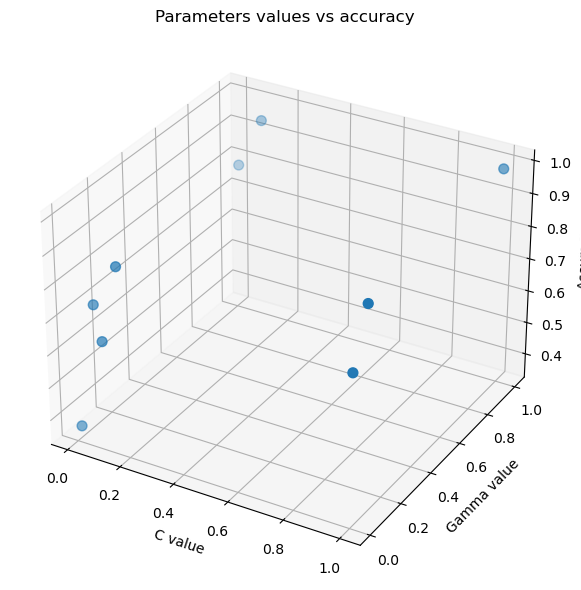

In [13]:
# Parameters for poly with higher degree kernel
parameters = {'C': [0.01, 0.1, 1],'gamma':[0.01,0.1, 1]}

# Define an SVM with poly of higher degree kernel (without parameters)
degree = 3
poly_svm = SVC(kernel = 'poly', degree=3) # ADD YOUR CODE HERE (replace None)

# Perform the K-fold cross validation
best, results = k_fold_cross_validation(X_train, y_train, k = num_folds, model = SVC, parameters = parameters) 
best_c.append(list(best[0].values()))
best_k.append('poly3')
best_acc.append(best[1])

print (f"RESULTS FOR POLY DEGREE={degree} KERNEL")

print("Best parameter set found:")
print(best[0])

print("Score with best parameter:")
print(best[1])

print("All scores on the grid:")
for param, score in results: print(param, score)
VALORI_PARAMETRO_1 = []
VALORI_PARAMETRO_2 = []
VALORI_ACCURACY = []
for i in range(len(results)):
    VALORI_PARAMETRO_1.append(list(results[i][0].values())[0])
    VALORI_PARAMETRO_2.append(list(results[i][0].values())[1])
    VALORI_ACCURACY.append(results[i][1])
    
#print(VALORI_PARAMETRO_1)
#print(VALORI_PARAMETRO_2)
#print(VALORI_ACCURACY)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(VALORI_PARAMETRO_1, VALORI_PARAMETRO_2, VALORI_ACCURACY, s = 50)
#plt.plot(VALORI_PARAMETRO, VALORI_ACCURACY, marker = 'o', linestyle='')

ax.set_xlabel("C value")
ax.set_ylabel("Gamma value")
ax.set_zlabel("Accuracy")
plt.title("Parameters values vs accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

### TO DO (A.5)

Pick a model for the Radial Basis Function kernel:

RESULTS FOR rbf KERNEL
Best parameter set found:
{'C': 10, 'gamma': 1}
Score with best parameter:
0.988
All scores on the grid:
{'C': 0.1, 'gamma': 0.001} 0.377
{'C': 0.1, 'gamma': 0.01} 0.655
{'C': 0.1, 'gamma': 0.1} 0.843
{'C': 0.1, 'gamma': 1} 0.945
{'C': 1, 'gamma': 0.001} 0.653
{'C': 1, 'gamma': 0.01} 0.789
{'C': 1, 'gamma': 0.1} 0.948
{'C': 1, 'gamma': 1} 0.983
{'C': 10, 'gamma': 0.001} 0.783
{'C': 10, 'gamma': 0.01} 0.894
{'C': 10, 'gamma': 0.1} 0.981
{'C': 10, 'gamma': 1} 0.988
{'C': 100, 'gamma': 0.001} 0.88
{'C': 100, 'gamma': 0.01} 0.959
{'C': 100, 'gamma': 0.1} 0.986
{'C': 100, 'gamma': 1} 0.987


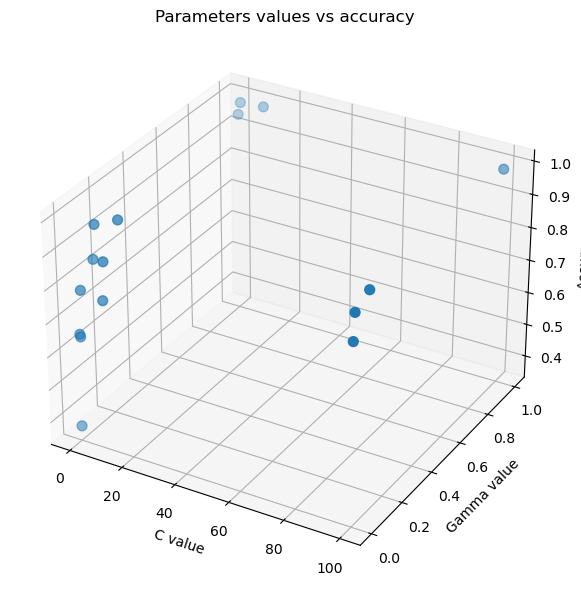

In [15]:
# Parameters for rbf SVM
parameters = {'C': [0.1, 1, 10, 100],'gamma':[0.001, 0.01, 0.1,1]}

# Define an SVM with rbf kernel (without parameters)
rbf_svm = SVC(kernel = 'rbf')
rbf_svm = k_fold_cross_validation(X_train, y_train, k = num_folds, model = SVC, parameters = parameters) 


# Perform the K-fold cross validation
best, results = k_fold_cross_validation(X_train, y_train, k = num_folds, model = SVC, parameters = parameters)  # ADD YOUR CODE HERE (replace None)
best_c.append(list(best[0].values()))
best_k.append('rbf')
best_acc.append(best[1])

print ('RESULTS FOR rbf KERNEL')

print("Best parameter set found:")
print(best[0])

print("Score with best parameter:")
print(best[1])

print("All scores on the grid:")
for param, score in results: print(param, score)
VALORI_PARAMETRO_1 = []
VALORI_PARAMETRO_2 = []
VALORI_ACCURACY = []
for i in range(len(results)):
    VALORI_PARAMETRO_1.append(list(results[i][0].values())[0])
    VALORI_PARAMETRO_2.append(list(results[i][0].values())[1])
    VALORI_ACCURACY.append(results[i][1])
    


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(VALORI_PARAMETRO_1, VALORI_PARAMETRO_2, VALORI_ACCURACY, s = 50)
#plt.plot(VALORI_PARAMETRO, VALORI_ACCURACY, marker = 'o', linestyle='')

ax.set_xlabel("C value")
ax.set_ylabel("Gamma value")
ax.set_zlabel("Accuracy")
plt.title("Parameters values vs accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()



### TO DO (A.Q1) [Answer the following]

What do you observe when using RBF and polynomial kernels on this dataset ?

**ANSWER A.Q1:**: The accuracy with the rbf kernel results to be higher. On this dataset, both the polynomial and rbf kernels work well. The accuracy of the polynomial kernel doesn't change with the increase of the degree of the polynomial, probably because the second degree polynomial can fit the data in the correct way.

### TO DO (A.6)
Report here the best SVM kernel and parameters

In [16]:
# Get training and test error for the best SVM model from CV
best_svm = max(best_acc) 
print("Best parameters are:", best_c[-1])

# Run the svm model on the whole training set

svm = SVC(kernel = best_k[-1]) #scelgo l'rbf come kernel 
svm.fit(X_train, y_train)


#Rivedere perché non funziona 
training_error = 1 - svm.score(X_train, y_train) 
test_error = 1 - svm.score(X_test, y_test) 

print ("Best SVM training error: %f" % training_error)
print ("Best SVM test error: %f" % test_error)

#Ottengo un errore pari a 0: impossibile, rivedere 

Best parameters are: [10, 1]
Best SVM training error: 0.021000
Best SVM test error: 0.018500


### TO DO (A.7)

Analyze how the gamma parameter (inversely proportional to standard deviation of Gaussian Kernel) impact the performances of the classifier

In [17]:
# Test with different values of gamma
# use rbf kernel and C=1

# Set gamma values
gamma_values = np.logspace(-5,2,8)
print(gamma_values)

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]


In [18]:
train_acc_list, test_acc_list = [], []

gauss_svm = SVC(kernel = 'rbf', gamma = False) #devo passargli diversi valori di gamma 
for i in (gamma_values):
    svm = SVC(**{'gamma':i})
    svm.fit(X_train, y_train) #effettuo il fit allenando l'algoritmo 
    y_pred = svm.predict(X_train) #predico i valori di y a partire dal training set 
    y_pred_test = svm.predict(X_test) #predico i valori di y a partire dal test set 
    
    y_pred = y_pred.ravel()
    y_pred_test = y_pred_test.ravel()
    
    #print(y_pred) #perché mi restituisce una lista soltanto con 0?
    train_acc_list.append(skm.accuracy_score(y_train, y_pred))
    test_acc_list.append(skm.accuracy_score(y_test, y_pred_test))

print("Training accuracy with different values of gamma: ", train_acc_list)
print("Test accuracy with different values of gamma: ", test_acc_list)



Training accuracy with different values of gamma:  [0.732, 0.732, 0.702, 0.829, 0.957, 0.989, 0.993, 1.0]
Test accuracy with different values of gamma:  [0.71925, 0.719, 0.6885, 0.81575, 0.955, 0.989, 0.98725, 0.91725]


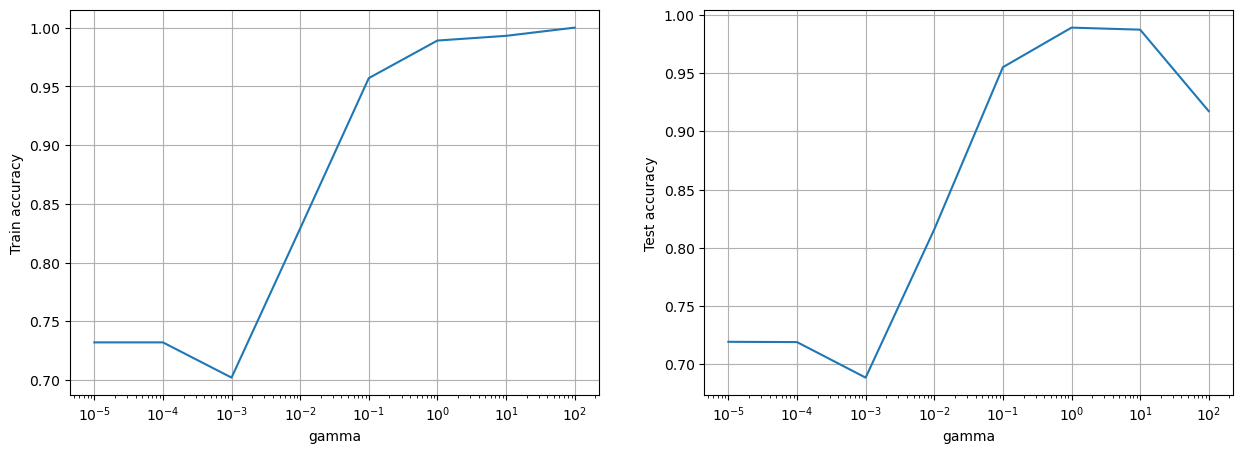

In [19]:
# Plot
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(gamma_values, train_acc_list)
ax[0].set_xscale('log')
ax[0].set_xlabel('gamma')
ax[0].set_ylabel('Train accuracy')
ax[0].grid(True)

ax[1].plot(gamma_values, test_acc_list)
ax[1].set_xscale('log')
ax[1].set_xlabel('gamma')
ax[1].set_ylabel('Test accuracy')
ax[1].grid(True)

plt.show()



## B) More data
Now let's do the same but using more data points for training.

### TO DO (B.0)

Choose a higher number of data points (e.g. x = 10000) for training data depending on your computing capability.

In [20]:
X = X[permutation]
y = y[permutation]

m_training = 10000 # ADD YOUR CODE: adjust depending on the capabilities of your PC (replace None)

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

labels, freqs = np.unique(y_train, return_counts=True) 

print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

# initialize support variables for boundaries visualization
granularity = 25
x_max = np.abs(X).max()
x_range = np.linspace(-x_max, x_max, granularity)
x_grid = np.stack(np.meshgrid(x_range, x_range, x_range)).reshape(3, -1).T

Labels in training dataset:  [0. 1. 2. 3.]
Frequencies in training dataset:  [3996 1691 3688  625]


### TO DO (B.1)

Let's try to use SVM with parameters obtained from the best model for $m_{training} =  10000$. Since it may take a long time to run, you can decide to just let it run for some time and stop it if it does not complete. If you decide to do this, report it in the TO DO (C.Q1) cell below.

In [21]:
# Get training and test error for the best SVM model from CV

best, results = k_fold_cross_validation(X_train, y_train, k = num_folds, model = SVC, parameters = parameters)  

In [22]:
rbf_svm = SVC(**best[0])

rbf_svm.fit(X_train, y_train)

training_error = 1 - svm.score(X_train, y_train)
test_error = 1 - svm.score(X_test, y_test)

print ("Best SVM training error: %f" % training_error)
print ("Best SVM test error: %f" % test_error)

Best SVM training error: 0.078300
Best SVM test error: 0.075505


## C) Boundaries Visualization

Now let us plot the classification boundaries. 

### TO DO (C.0)

Use the SVM to predict on the test set X_test. 

In [23]:

rbf_svm_test = svm.predict(X_test) 

We constructed a grid of all possible combinations of input values, we now use it to extract the classification boundaries of the three classifiers by having them predict on each input.

(-2.7020420042855027, 2.7020420042855027)

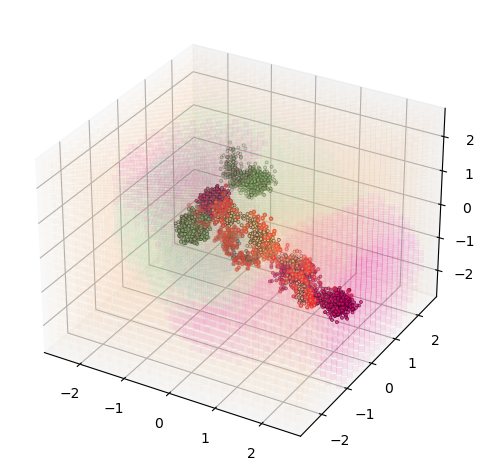

In [27]:
rbf_SVM_grid = rbf_svm.predict(x_grid)

rbf_SVM_m = y_test == rbf_svm_test

fig = plt.figure(figsize=(20,36))
ax1 = fig.add_subplot(1, 3, 1, projection="3d")


ax1.scatter(x_grid[:,0], x_grid[:,1], x_grid[:,2], c=rbf_SVM_grid, linewidth=0, marker="s", alpha=.05,cmap='Accent')

ax1.scatter(X_test[rbf_SVM_m,0], X_test[rbf_SVM_m,1], X_test[rbf_SVM_m,2], c=y_test[rbf_SVM_m], linewidth=.5, edgecolor="k", marker=".",cmap='Accent')
ax1.scatter(X_test[~rbf_SVM_m,0], X_test[~rbf_SVM_m,1], X_test[~rbf_SVM_m,2], c=y_test[~rbf_SVM_m], linewidth=1, edgecolor="r", marker=".",cmap='Accent')
ax1.set_xlim([-x_max, x_max])
ax1.set_ylim([-x_max, x_max])
ax1.set_zlim([-x_max, x_max])

### TO DO (C.Q1) [Answer the following]**

Compare and discuss the results from SVM with m=600 and with m=10000 (or whatever value you set) training data points. If you stopped the SVM, include such aspect in your comparison.

**ANSWER C.Q1:** We can observe that with m=10000 the error both on training and test sets are higher. In particular, for m=10000 we obtain training error = 0.079 and test error = 0.074, while for m = 600 the error for training is 0.021 and on test is 0.018. This can be due to the fact that in the first case (m=600) we are iterating over a small dataset, while in the second case the dataset is bigger and consequently the misclassified samples will be more. 

### TO DO (C.1)

Plot the confusion matrix for the SVM classifier. The confusion matrix has one column for each predicted label and one row for each true label. 
It shows for each class in the corresponding row how many samples belonging to that class gets each possible output label. Notice that the diagonal contains the correctly classified samples, while the other cells correspond to errors. You can obtain it with the sklearn.metrics.confusion_matrix function (see the documentation). You can also print also the normalized confusion matrix.


In [25]:
from sklearn.metrics import confusion_matrix

np.set_printoptions(precision=2, suppress=True) # for better aligned printing of confusion matrix use floatmode='fixed'

u, counts = np.unique(y_test, return_counts=True)
print("Labels and frequencies in test set: ", counts)

confusion_SVM = confusion_matrix(y_test, rbf_svm_test)
print("\n Confusion matrix SVM  \n \n", confusion_SVM)
print("\n Confusion matrix SVM (normalized)   \n \n", confusion_SVM /counts[:,None] )

Labels and frequencies in test set:  [2122  837 1835  305]

 Confusion matrix SVM  
 
 [[2122    0    0    0]
 [ 157  655   25    0]
 [  23   25 1787    0]
 [ 155    0    0  150]]

 Confusion matrix SVM (normalized)   
 
 [[1.   0.   0.   0.  ]
 [0.19 0.78 0.03 0.  ]
 [0.01 0.01 0.97 0.  ]
 [0.51 0.   0.   0.49]]


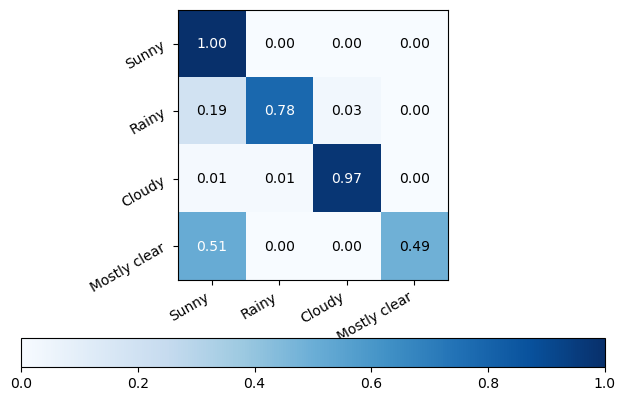

In [26]:
fig = plt.figure()
    
im = plt.imshow(confusion_SVM /counts[:,None], cmap="Blues",interpolation='nearest')
plt.xticks([0,1,2,3], ['Sunny', 'Rainy','Cloudy', 'Mostly clear'],ha="right",rotation=30)
plt.yticks([0,1,2,3], ['Sunny', 'Rainy','Cloudy', 'Mostly clear'],ha="right",rotation=30)
cm = confusion_SVM /counts[:,None]
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
fig.colorbar(im, location='bottom')  
plt.show()

### TO DO (C.Q2) [Answer the following]

Have a look at the confusion matrix and comment on the obtained accuracies. Why some classes have lower accuracies and others an higher one? Make some guesses on the possible causes.

**ANSWER C.Q2:** The sunny and cloudy classes have a higher accuracy, while in the case of rainy and mostly clear, it results to be lower. This can be given by the fact that the training set that is being used presents a smaller percentage of labels related to these two classes. Consequently the algorithm is not trained well on these data.
Also we can observe that the algorithm fails to classify samples in classes that are characterized by similar parameters, like in the mostly clear label: half of the samples are incorrectly classified with the sunny label. Here we can hypotize that this error is given by the fact that values of humidity, temperature and atmospheric pressure are similar for these two labels.